<div style="font-weight: bold" align="center">
    <div style="font-size: xx-large; color:#3d6f91">Teoría de la Información</div><br>
    <div style="font-size: x-large; color:gray">Análisis spikes neuronales</div><br>
    <div style="font-size: large; color: #5D8AA8">Óscar Gómez Borzdynski y Alejandro Cabana Suárez</div><br></div><hr>
</div>

In [1]:
%%html
<style>
    h1, h2, h3 {color: #3d6f91;}
    b {color: #5D8AA8;}
    p, li {font-size: large}
</style>

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from utils import *
import pickle
import seaborn as sns
import os.path

<b>Nota:</b> Hemos desactivado algunas celdas de código ya que tardan mucho en ejecutarse. En caso de querer ejecutar el notebook completo necesitarás crear una carpeta `DatosSinapsisArtificial` con los `.txt` de los datos originales y armarte de paciencia.

# Análisis inicial
Comenzamos analizando los datos proporcionados por el profesor.

En primer lugar vemos la necesidad de encontrar los picos de cada una de las series temporales, para ello decidimos implementar la función `get_spikes()` que sigue el siguiente pseudo-código:

<hr>

```
crear una serie del mismo tamaño rellena de 0's

a lo largo de la serie:

    if ((serie supera threshold superior) y (no estamos ya dentro de un spike)) :
        marcar inicio spike
        
    if ((serie desciende de threshold inferior) y (estamos en un spike)) :
        marcar fin spike
        obtener el índice del máximo dentro del spike
        colocar un 1 en la serie para dicho índice
        
devolver la serie    
```

<hr>

Para definir los thresholds dibujamos el comienzo de las series. En las gráficas de debajo hemos colocado líneas horizontales en los thresholds escogidos.

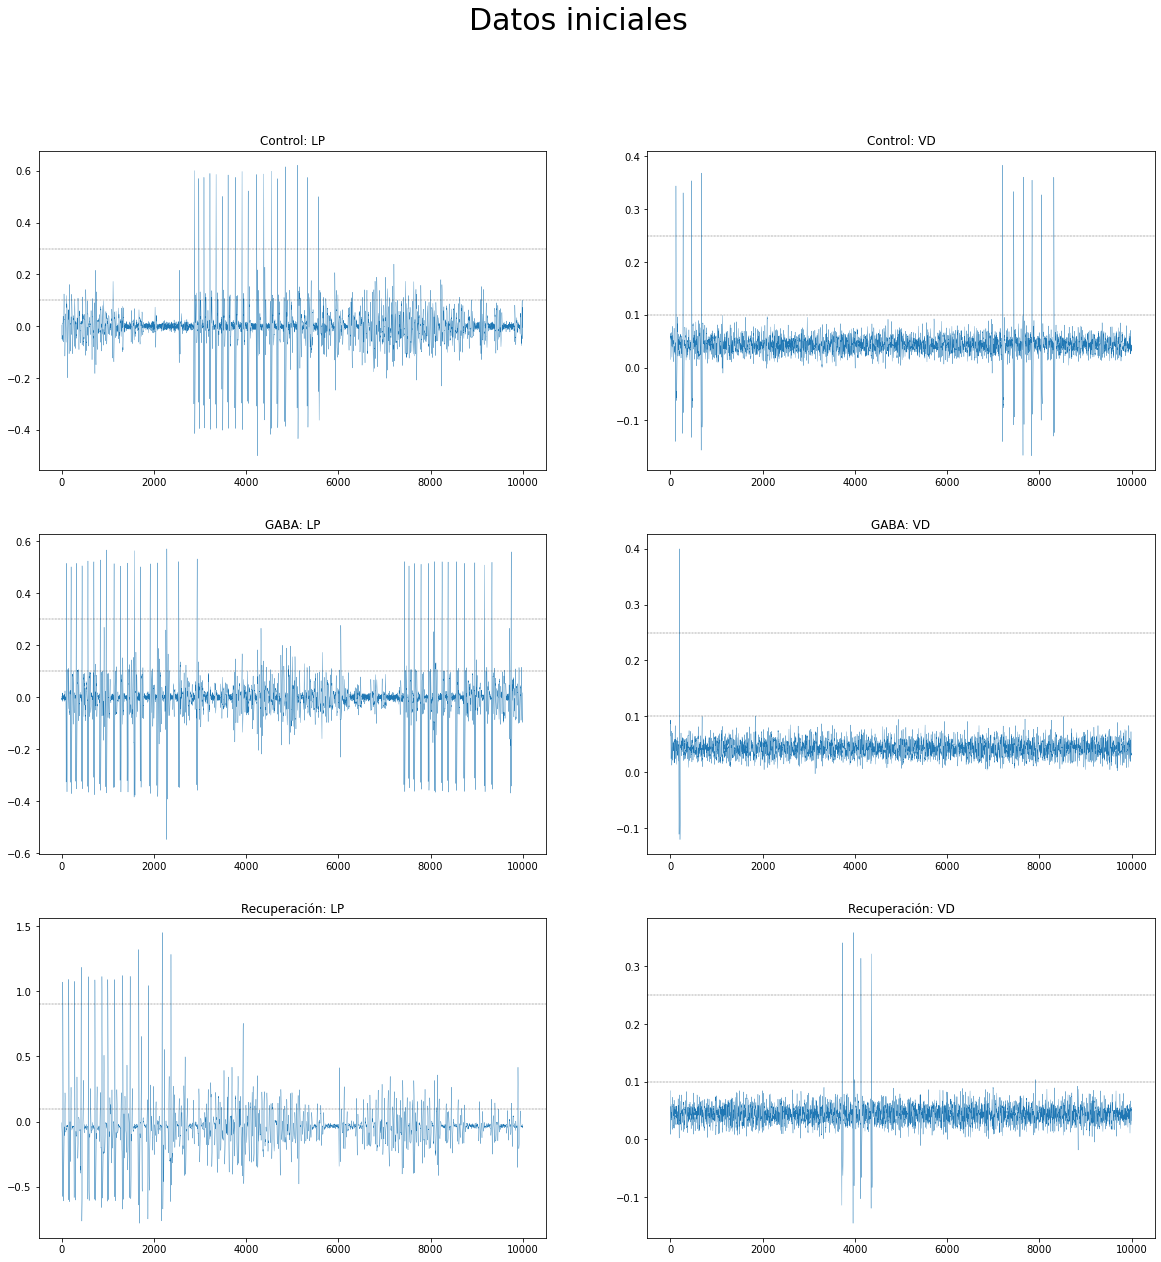

In [3]:
from_files = ["./DatosSinapsisArtificial/TrozoC.txt",
              "./DatosSinapsisArtificial/TrozoG.txt",
              "./DatosSinapsisArtificial/TrozoR.txt"]
cols = [["LP", "VD"],
        ["LP", "VD", "GABA"],
        ["LP", "VD"]]
thresholds = [{"LP": [0.3, 0.1], "VD": [0.25, 0.1]},
              {"LP": [0.3, 0.1], "VD": [0.25, 0.1]},
              {"LP": [0.9, 0.1], "VD": [0.25, 0.1]}]
titles = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Datos iniciales", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], skiprows=3, 
                     header=None, names=cols[i], dtype=np.float,
                     sep='\s+', decimal=',', index_col=False).head(10000)
    
    plt.subplot(3,2,2*i+1)
    plt.plot(df["LP"], lw=0.3)
    plt.axhline(y=thresholds[i]["LP"][0], ls="-.", c='black', lw=0.3)
    plt.axhline(y=thresholds[i]["LP"][1], ls="-.", c='black', lw=0.3)
    plt.title(f"{titles[i]}: LP")
    
    plt.subplot(3,2,2*i+2)
    plt.plot(df["VD"], lw=0.3)
    plt.axhline(y=thresholds[i]["VD"][0], ls="-.", color='black', lw=0.3)
    plt.axhline(y=thresholds[i]["VD"][1], ls="-.", color='black', lw=0.3)
    plt.title(f"{titles[i]}: VD")

# Spikes

En las gráficas siguientes vemos los puntos escogidos por la función `get_spikes()`, estos puntos están expresados por cruces en dichas posiciones.

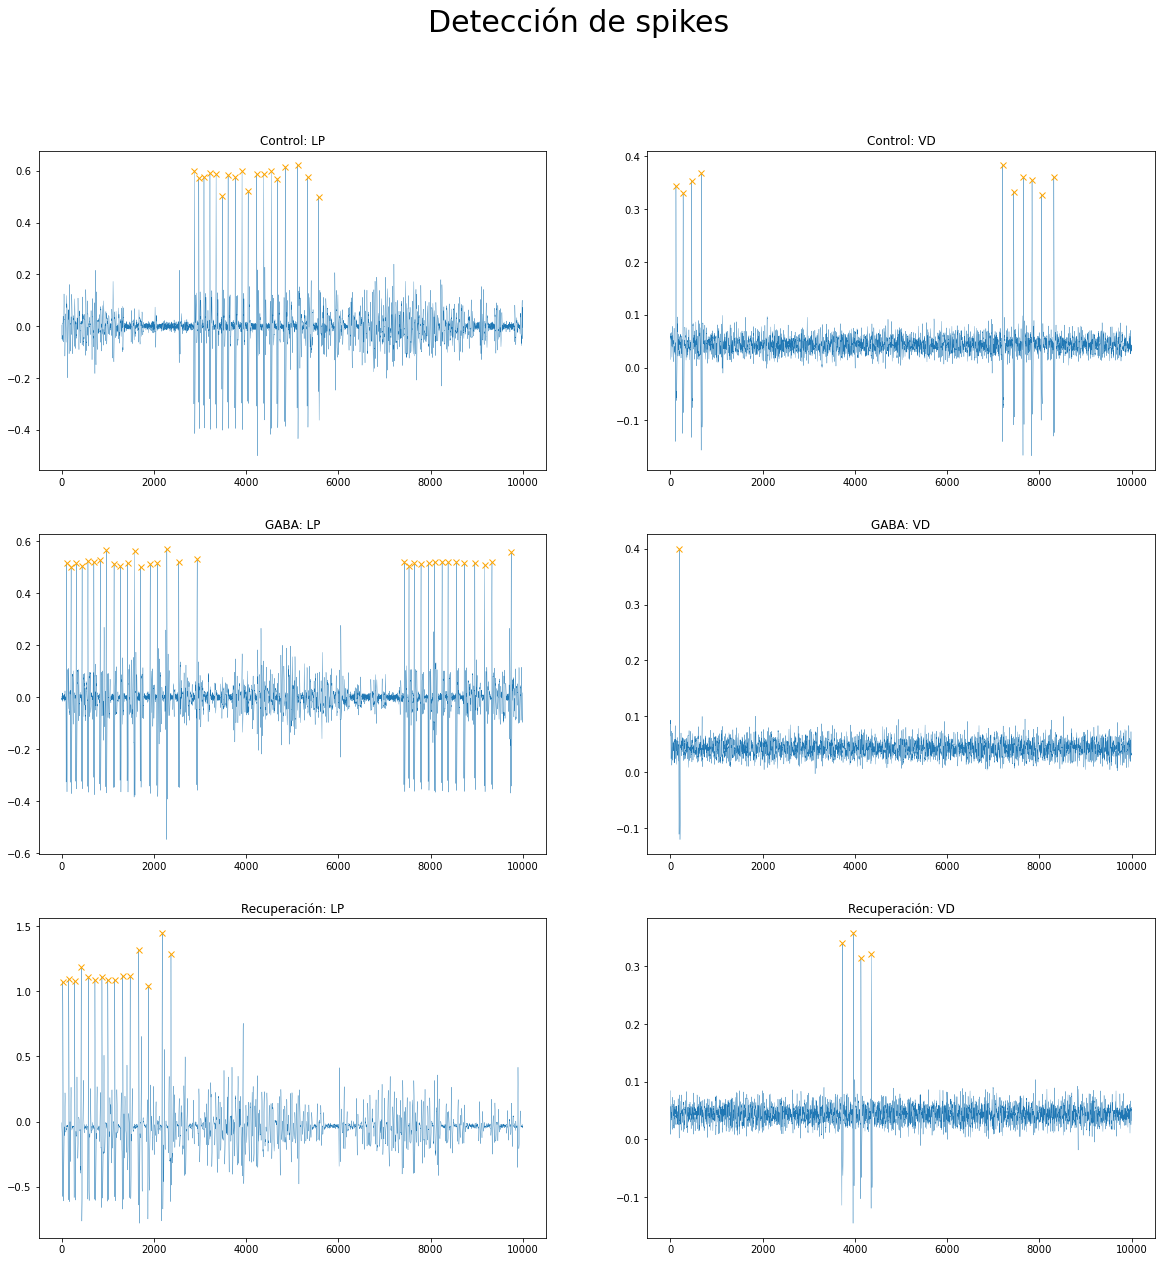

In [5]:
from_files = ["./DatosSinapsisArtificial/TrozoC.txt",
              "./DatosSinapsisArtificial/TrozoG.txt",
              "./DatosSinapsisArtificial/TrozoR.txt"]
bin_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
             "./DatosSinapsisArtificial/TrozoG_bin.csv",
             "./DatosSinapsisArtificial/TrozoR_bin.csv"]
cols = [["LP", "VD"],
        ["LP", "VD", "GABA"],
        ["LP", "VD"]]
titles = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Detección de spikes", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], skiprows=3, 
                     header=None, names=cols[i], dtype=np.float, sep='\s+', decimal=',', index_col=False, nrows=10000)
    df2 = pd.read_csv(bin_files[i],nrows=10000)
    
    plt.subplot(3,2,2*i+1)
    plt.plot(df["LP"], lw=0.3)
    plt.plot(df2[df2["LP_bin"] == 1]["LP"], 'x', c='orange')
    plt.title(f"{titles[i]}: LP")
    
    plt.subplot(3,2,2*i+2)
    plt.plot(df["VD"], lw=0.3)
    plt.plot(df2[df2["VD_bin"] == 1]["VD"], 'x', c='orange')
    plt.title(f"{titles[i]}: VD")

Estas gráficas representan un fragmento de la serie con los spikes etiquetados. Las cruces naranjas representan los unos en la serie y se ubican en el punto con valor máximo de cada spike.

# Distancia entre spikes

En esta práctica debemos calcular:

* Entropía
* Información mutua
* Entropía normalizada

Para todos estos cálculos debemos decidir 2 parámetros, el tamaño de bin, al que hemos llamado resolución y el tamaño de palabra (cuántos bins se analizan simultáneamente). En todos los casos hemos decidido tomar un tamaño de palabra máximo de 8 bins. 

Para decidir la resolución, obtenemos un histograma de la distancia entre spikes consecutivos. Hemos colocado una barra vertical en la resolución máxima que calcularemos. Hemos escogido este límite pese a que en algunos casos introducimos más de un spike en un solo bin. Dado que calcularemos todas las resoluciones entre 1 y ese límite, podremos analizar qué consecuencias tiene seleccionar un tamaño de bin demasiado grande.

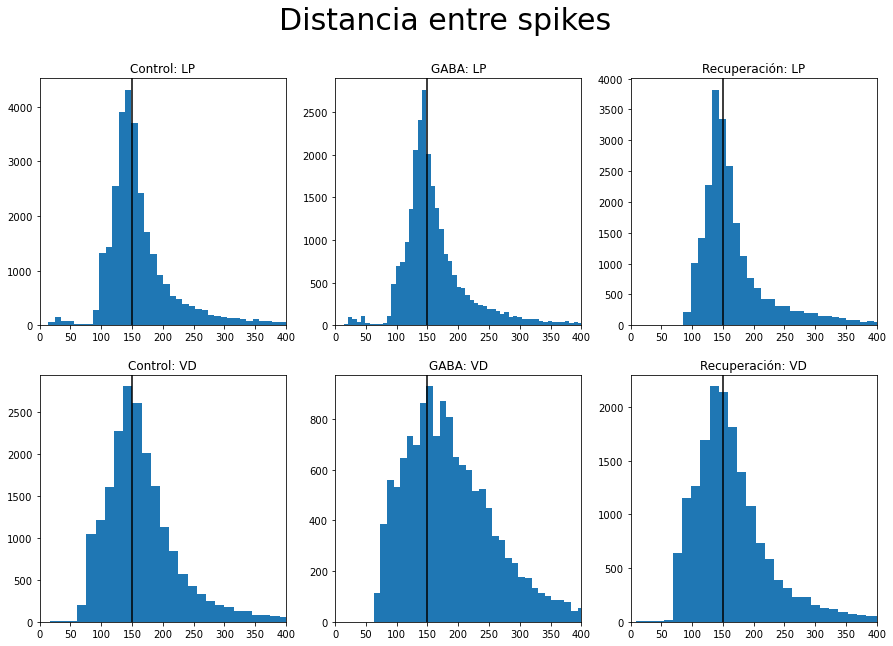

In [6]:
from_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
              "./DatosSinapsisArtificial/TrozoG_bin.csv",
              "./DatosSinapsisArtificial/TrozoR_bin.csv"]
titles = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,10))
fig.suptitle("Distancia entre spikes", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], usecols=['LP_bin', 'VD_bin'])
    df = df.astype({"LP_bin":'u1', "VD_bin":'u1'})

    w = df.index[df.LP_bin > 0]
    w = w[1:] - w[:-1]

    plt.subplot(2, 3, i+1)
    plt.hist(w,bins=2000)
    plt.axvline(x=150, color='k')
    plt.xlim((0, 400))
    plt.title(f"{titles[i]}: LP")
    
    w = df.index[df.VD_bin > 0]
    w = w[1:] - w[:-1]

    plt.subplot(2, 3, i+4)
    plt.hist(w,bins=2000)
    plt.axvline(x=150, color='k')
    plt.xlim((0, 400))
    plt.title(f"{titles[i]}: VD")

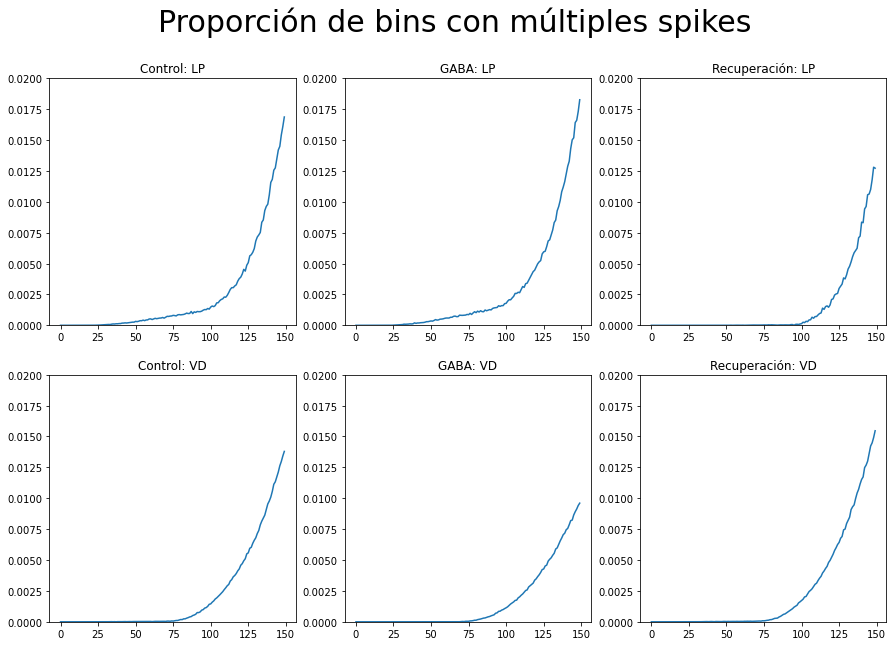

In [12]:
from_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
              "./DatosSinapsisArtificial/TrozoG_bin.csv",
              "./DatosSinapsisArtificial/TrozoR_bin.csv"]
titles = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,10))
fig.suptitle("Proporción de bins con múltiples spikes", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], usecols=['LP_bin', 'VD_bin'])
    df = df.astype({"LP_bin":'u1', "VD_bin":'u1'})
    
    ers = [get_error_proportion(df, i) for i in range(1,151)]
    ers_LP = [a.LP_bin for a in ers]
    ers_VD = [a.VD_bin for a in ers]

    plt.subplot(2, 3, i+1)
    plt.plot(ers_LP)
    plt.ylim((0,0.020))
    plt.title(f"{titles[i]}: LP")

    plt.subplot(2, 3, i+4)
    plt.plot(ers_VD)
    plt.ylim((0,0.020))
    plt.title(f"{titles[i]}: VD")

En estos histogramas podemos observar ciertas distancias entre spikes demasiado pequeñas para ser reales, pensamos que se pueden corresponder a alguna clase de error. De hecho se puede ver que están algo separados del cuerpo de la distribución.

En la mayoría de los casos el valor de resolución que deberíamos seleccionar para dejar fuera solo estos errores es de aproximadamente 60, pero llegando al máximo del histograma esperamos escoger la distancia más habitual. En el segundo grupo de gráficas observamos la proporción de bins que contienen más de un spike. Es importante calcular este valor para comprobar que es poco frecuente y que afectará poco a los resultados de esta práctica. Vemos que su valor máximo es de $1.8\%$.

Para modificar la resolución de las series obtenidas previamente definimos la función `resolution()` que sigue el siguiente pseudocódigo:

<hr>

```
dividir la serie en fragmentos de tamaño máximo igual a la resolución

para cada fragmento:
    si no existe ningún spike en la serie original -> 0
    si existe algún spike en la serie original -> 1
    
reagrupar todos los fragmentos en una serie de tamaño techo(tamaño original/resolución)
```

<hr>

Luego para calcular las métricas definimos la función `transfer_info()` que sigue el siguiente pseudocódigo:

<hr>

```
dividir la serie en palabras solapadas de tamaño longitud de la palabra

para cada palabra:
    transformar a decimal el número binario representado en la palabra
    combinar los números de las dos columnas a analizar (para la entropía conjunta) 
    
obtener las probabilidades de aparición de cada posible valor

calcular las entropías de cada columna
calcular la entropía conjunta
calcular la información mutua como la suma de las entropías individuales menos la conjunta
calcular las entropías normalizadas

devolver todos los valores calculados
```

<hr>

Guardamos todos los cálculos realizados en ficheros específicos para cada fragmento de datos.


# Entropía normalizada

Una vez realizados todos los cálculos podemos pasar a evaluar los resultados obtenidos

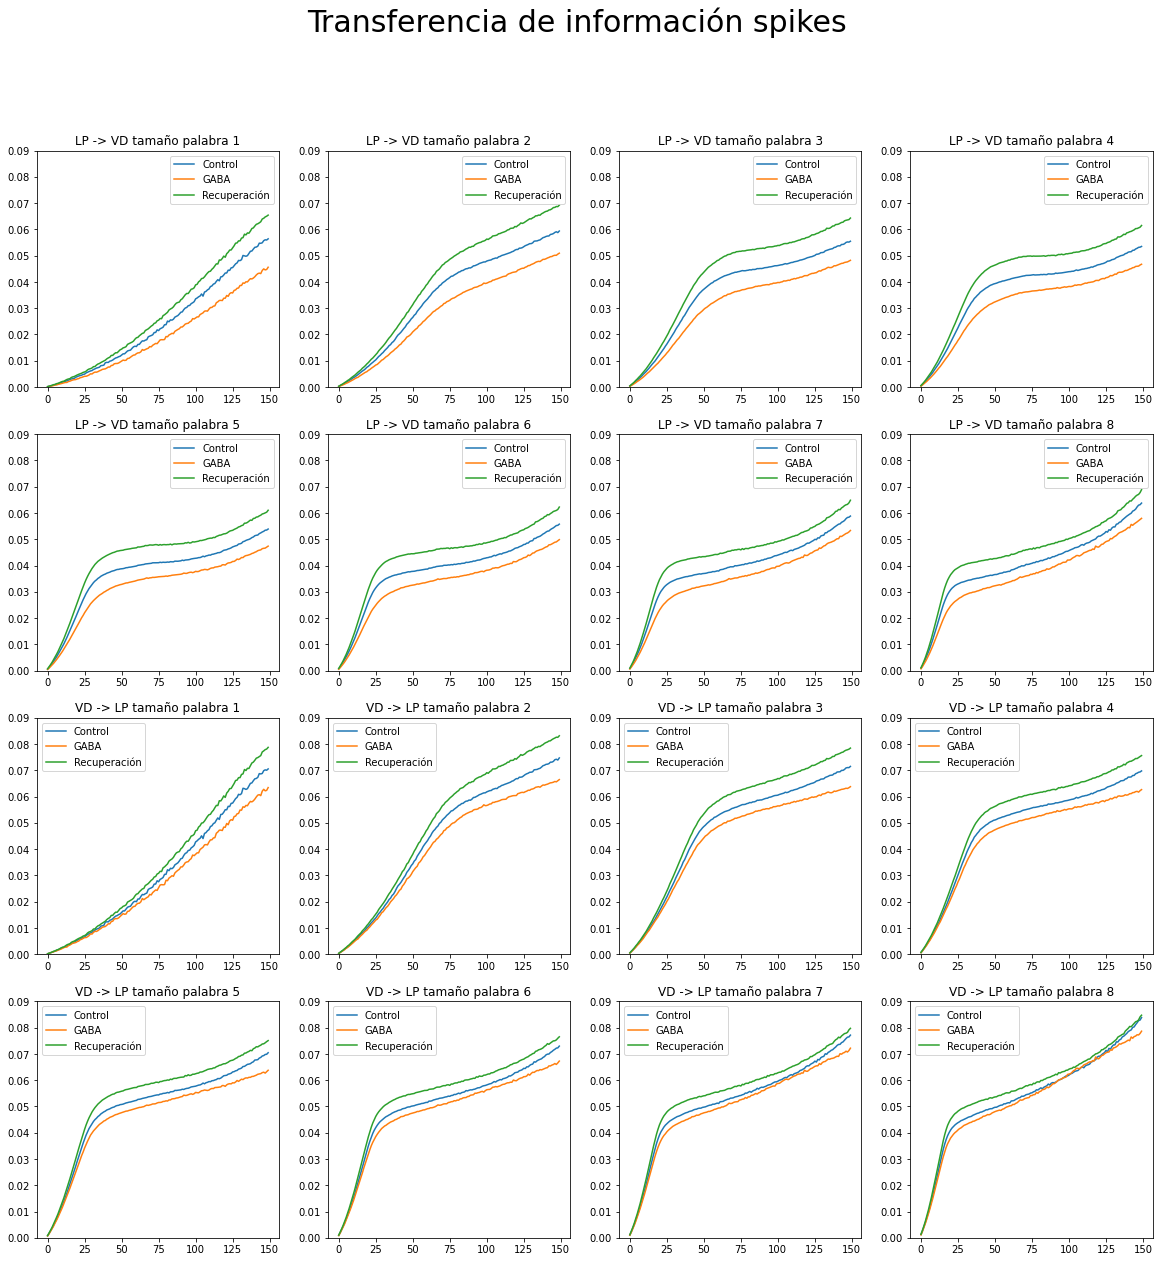

In [36]:
from_files = ["dataC.pkl",
              "dataG.pkl",
              "dataR.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Transferencia de información spikes", fontsize=30)

for w in range(1,9):
    plt.subplot(4, 4, w)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["transfer_info_col1_col2"].reset_index(drop=True, inplace=True)
            plt.plot(data["transfer_info_col1_col2"][f"word_len {w}"], label=labels[i])
    plt.legend()
    plt.ylim((0,0.09))
    plt.title(f"LP -> VD tamaño palabra {w}")
    plt.subplot(4, 4, w+8)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["transfer_info_col2_col1"].reset_index(drop=True, inplace=True)
            plt.plot(data["transfer_info_col2_col1"][f"word_len {w}"], label=labels[i])
    plt.title(f"VD -> LP tamaño palabra {w}")
    plt.ylim((0,0.09))
    plt.legend()

Lo primero que destaca es la similitud entre los 3 casos, Control, GABA y Recuperación, lo que quizás nos da una intuición de que los datos vienen de fuentes que están relacionadas entre sí. También nos llama la atención el cambio de pendiente que sucede en casi todas las gráficas. Este cambio se produce con tamaños de bin más bajos conforme aumenta el tamaño de palabra. Tras analizar en detalle estos valores, vemos que corresponden aproximadamente a $\frac{150}{tamaño\_palabra}$. Podemos intuir con esta información que hay alguna clase de cambio en los datos cuando superamos este tamaño de bin.

Por otra parte, vemos que la transferencia de información cuando se inyecta GABA es inferior en todos los casos, esto puede indicar que la presencia de GABA reduce la influencia de una neurona en la otra, o que, de alguna manera, introduce ruido en el canal de comunicación.

Además, vemos que la transferencia de información de VD a LP es algo mayor que de LP a VD. Para comprobarlo mejor, realizamos las siguientes gráficas, donde vemos mediante un mapa de calor la transferencia de información en ambos sentidos. Podemos apreciar que es cierto que la transferencia de información de VD a LP es mayor que en el sentido opuesto.

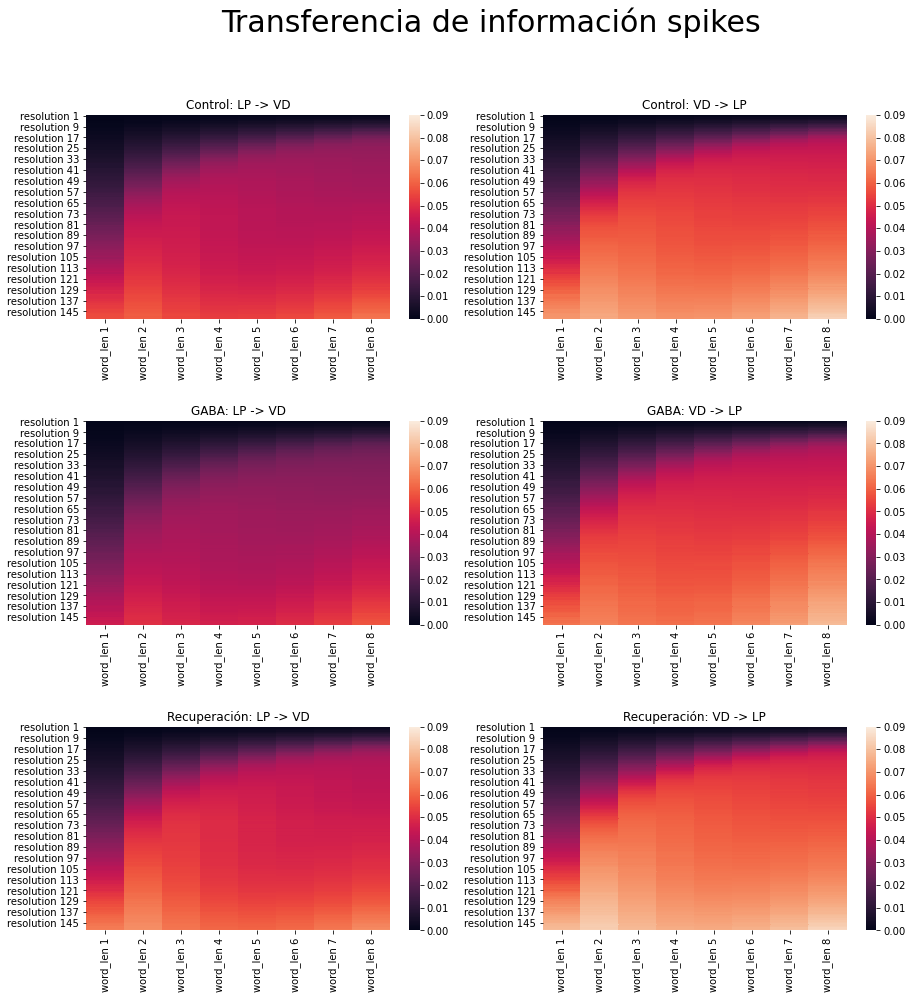

In [37]:
from_files = ["dataC.pkl",
              "dataG.pkl",
              "dataR.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,15))
fig.suptitle("Transferencia de información spikes", fontsize=30)
plt.subplots_adjust(hspace=0.5)
for i in range(len(from_files)):
    with open(from_files[i], "rb") as f:
        data = pickle.load(f)
    plt.subplot(3, 2, 2*i + 1)
    sns.heatmap(data['transfer_info_col1_col2'].convert_dtypes(), vmin=0, vmax=0.09)
    plt.title(f"{labels[i]}: LP -> VD")
    plt.subplot(3, 2, 2*i + 2)
    sns.heatmap(data['transfer_info_col2_col1'].convert_dtypes(), vmin=0, vmax=0.09)
    plt.title(f"{labels[i]}: VD -> LP")

Dado que la transferencia de información es la división de la información mutua entre la entropía del estímulo, decidimos analizar cada una de estas variables por separado.

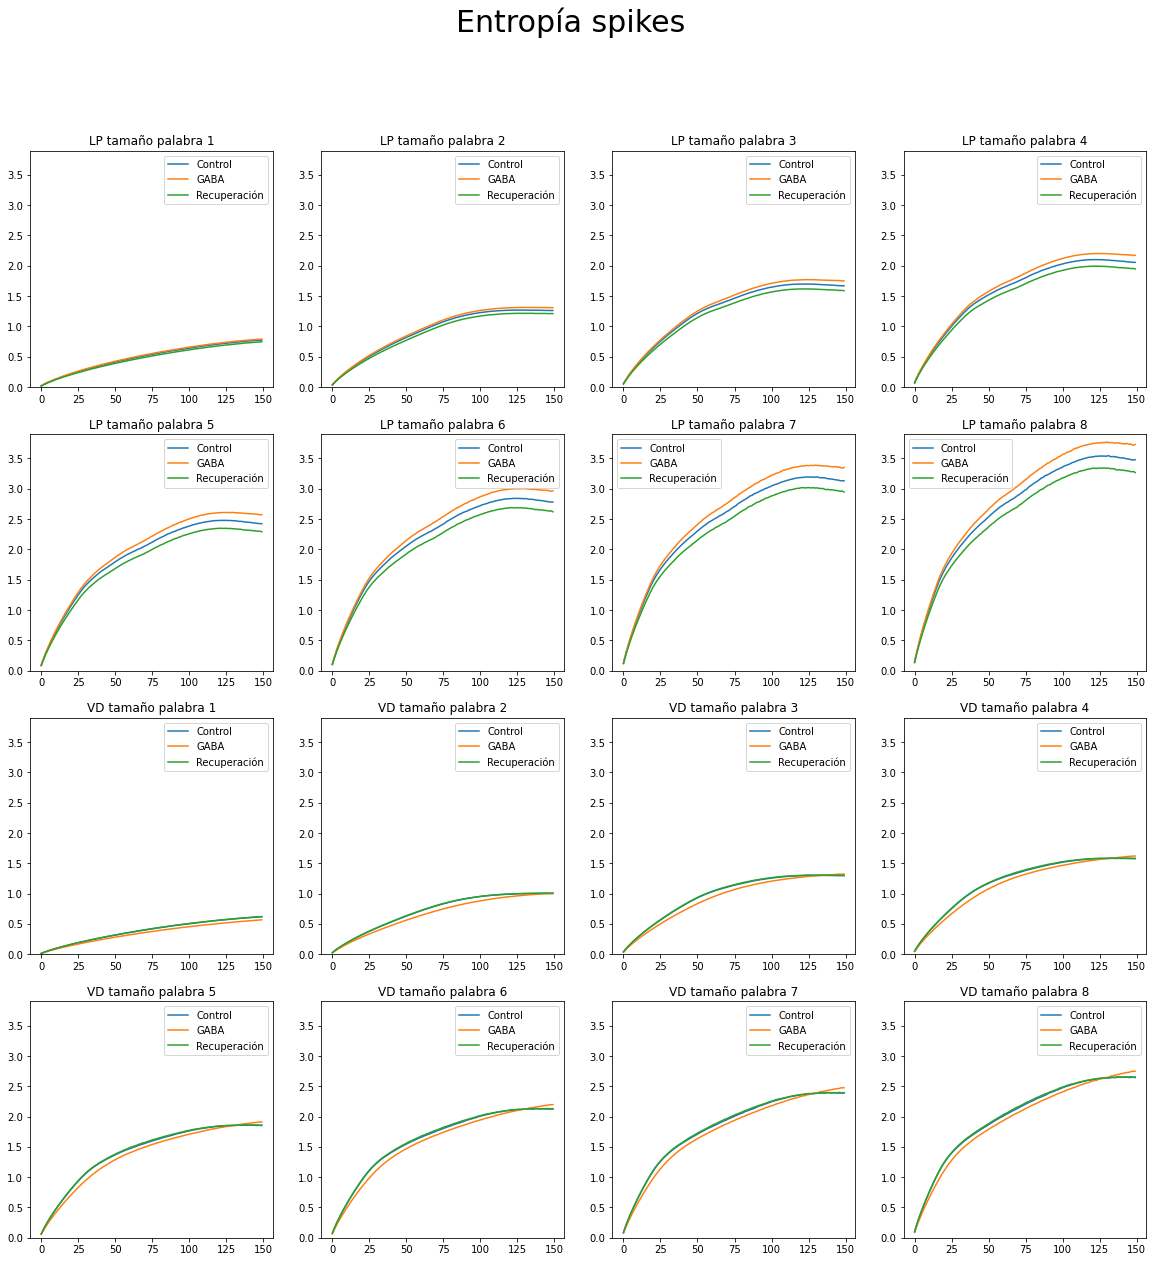

In [28]:
from_files = ["dataC.pkl",
              "dataG.pkl",
              "dataR.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Entropía spikes", fontsize=30)

for w in range(1,9):
    plt.subplot(4, 4, w)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["col1_entropy"].reset_index(drop=True, inplace=True)
            plt.plot(data["col1_entropy"][f"word_len {w}"], label=labels[i])
    plt.legend()
    plt.title(f"LP tamaño palabra {w}")
    plt.ylim((0,3.9))
    plt.subplot(4, 4, w+8)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["col2_entropy"].reset_index(drop=True, inplace=True)
            plt.plot(data["col2_entropy"][f"word_len {w}"], label=labels[i])
    plt.title(f"VD tamaño palabra {w}")
    plt.ylim((0,3.9))
    plt.legend()

En estas gráficas podemos apreciar un cambio de monotonía similar al presente en la transferencia de información. Pensamos que esto puede deberse a la distancia entre spikes:

Para tamaños de bin pequeños, las palabras que aparecen en las series estarán formadas mayoritariamente por todo ceros o todo ceros salvo un uno ya que no hay spikes lo suficientemente juntos como para que una palabra abarque más de uno de ellos. De entre estos casos, el más frecuente con diferencia será el de todo ceros, que podemos encontrar entre dos spikes del mismo burst o entre dos bursts (el más común).

El número 150 coincide con la distancia entre spikes más habitual. Con esto en mente, podemos interpretar $\frac{150}{tamaño\_palabra}$ como el tamaño de bin que hace que la palabra mida esta distancia en total. Al superar este tamaño de bin, las palabras empezarán a contener más de un spike.

Para tamaños pequeños la entropía es baja, ya que las probabilidades de los eventos que aparecen están muy desequilibradas: La palabra todo ceros tiene probabilidad muy alta mientras que las palabras con un solo 1 se reparten el resto de la probabilidad. Aumentando el tamaño de bin lo que se consigue es disminuir el número total de ceros en la serie, manteniendo el número de unos. Esto provoca que la palabra con todo ceros aparezca menos veces pero se mantenga el número de apariciones del resto de palabras. De esta manera, la probabilidad de dicha palabra es menor y en consecuencia, la del resto crece proporcionalmente, aumentando la entropía.

Esto continúa así hasta que las palabras empiezan a contener más de un spike: aproximadamente en $\frac{150}{tamaño\_palabra}$. A partir de este tamaño, dentro de un burst dejará de aparecer la palabra de ceros, de forma que la proporción de apariciones de esta palabra que se reduce al aumentar el tamaño de bin es menor, cambiando el ritmo de crecimiento de la entropía.

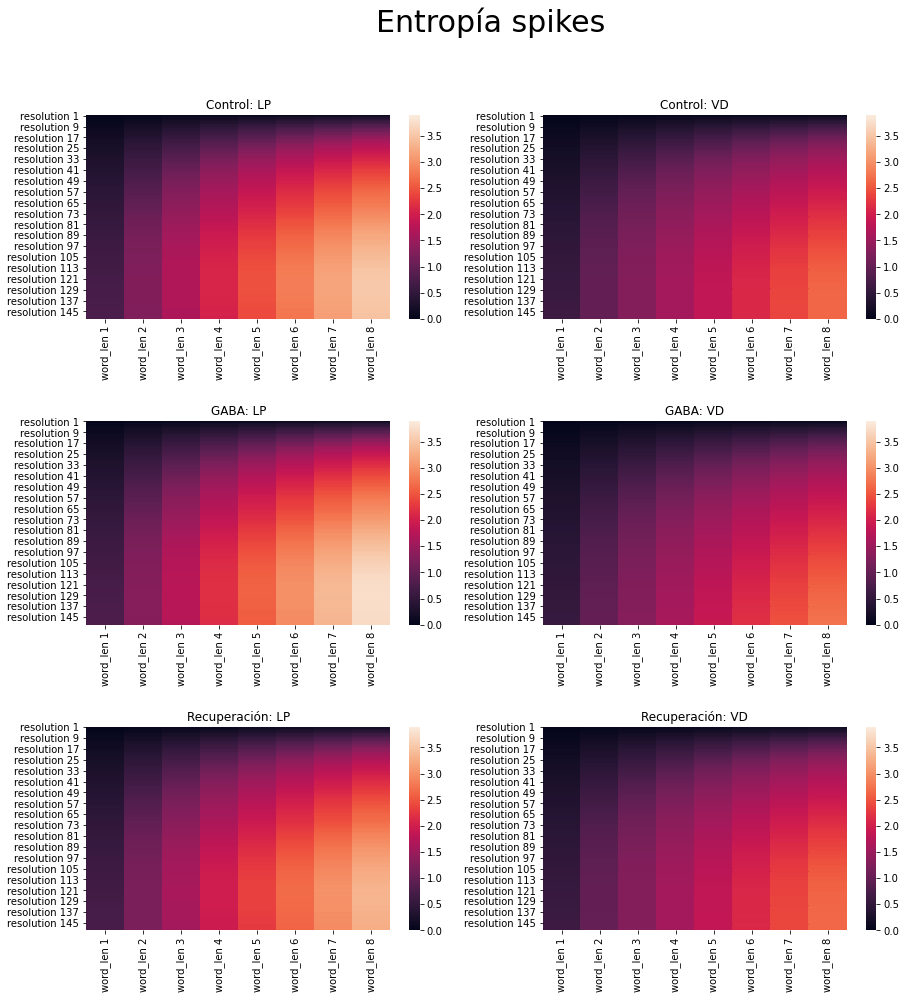

In [29]:
from_files = ["dataC.pkl",
              "dataG.pkl",
              "dataR.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,15))
fig.suptitle("Entropía spikes", fontsize=30)
plt.subplots_adjust(hspace=0.5)
for i in range(len(from_files)):
    with open(from_files[i], "rb") as f:
        data = pickle.load(f)
    plt.subplot(3, 2, 2*i + 1)
    sns.heatmap(data['col1_entropy'].convert_dtypes(), vmin=0, vmax=3.9)
    plt.title(f"{labels[i]}: LP")
    plt.subplot(3, 2, 2*i + 2)
    sns.heatmap(data['col2_entropy'].convert_dtypes(), vmin=0,vmax=3.9)
    plt.title(f"{labels[i]}: VD")

Vemos que la entropía de LP es mayor que la de VD (colores más claros), lo que jutsifica que la entropía normalizada (transferencia de información) sea mayor de VD a LP que al contrario.

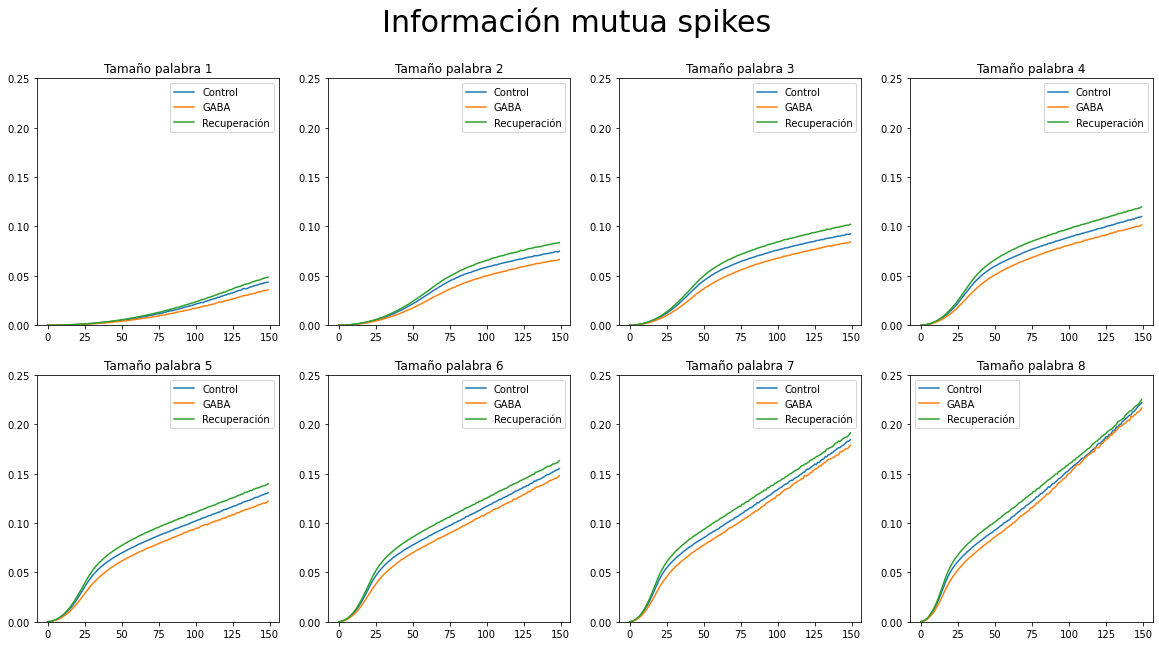

In [5]:
from_files = ["dataC.pkl",
              "dataG.pkl",
              "dataR.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,10))
fig.suptitle("Información mutua spikes", fontsize=30)

for w in range(1,9):
    plt.subplot(2, 4, w)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["mutual_info"].reset_index(drop=True, inplace=True)
            plt.plot(data["mutual_info"][f"word_len {w}"], label=labels[i])
    plt.legend()
    plt.title(f"Tamaño palabra {w}")
    plt.ylim((0,0.25))

Comprobamos que en la información mutua tenemos el mismo fenómeno en las mismos tamaños de bin, aunque en mayor medida. Pensamos que el mismo razonamiento que en la situación anterior se puede aplicar a este caso.

# Codificación por bursts

Como seguna codificación decidimos seleccionar los bursts en vez de los spikes. Un burst está caracterizado por una agrupación de spikes cercanos en el tiempo con una separación clara entre bursts. Para ello implementamos la función `get_bursts()` que sigue el siguiente pseudocódigo:

<hr>

```-----------------------------------------------------------------------------------------------------------¶
crear una serie del mismo tamaño rellena de 0's

a lo largo de la serie original:
    obtener la distancia entre spikes
    si la distancia es mayor que un valor prefijado:
        colocar un 1 en esa posición de la serie nueva
    
devolver la nueva serie
```

<hr>

De esta manera estamos colocando un 1 en el primer spike de cada burst.

Para seleccionar la distancia mínima a la que dos spikes consideramos que están en distintos bursts, ampliamos el histograma de distancia entre spikes en busca de spikes muy separados que caractericen el cambio de burst. Hemos dibujado una linea vertical en el valor seleccionado. El eje y está truncado a 1000 para facilitar la visualización de los datos.

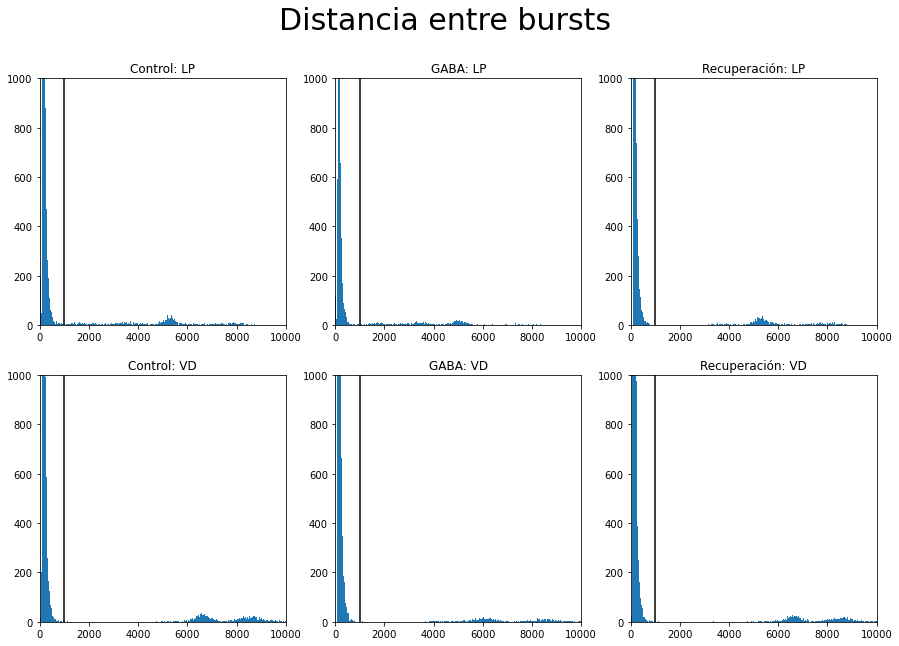

In [11]:
from_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
              "./DatosSinapsisArtificial/TrozoG_bin.csv",
              "./DatosSinapsisArtificial/TrozoR_bin.csv"]
titles = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,10))
fig.suptitle("Distancia entre bursts", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], usecols=['LP_bin', 'VD_bin'])
    df = df.astype({"LP_bin":'u1', "VD_bin":'u1'})

    w = df.index[df.LP_bin > 0]
    w = w[1:] - w[:-1]

    plt.subplot(2, 3, i+1)
    plt.hist(w,bins=1000)
    plt.axvline(x=1000, color='k')
    plt.xlim((0, 10000))
    plt.ylim((0,1000))
    plt.title(f"{titles[i]}: LP")
    
    w = df.index[df.VD_bin > 0]
    w = w[1:] - w[:-1]

    plt.subplot(2, 3, i+4)
    plt.hist(w,bins=1000)
    plt.axvline(x=1000, color='k')
    plt.xlim((0, 10000))
    plt.ylim((0,1000))
    plt.title(f"{titles[i]}: VD")

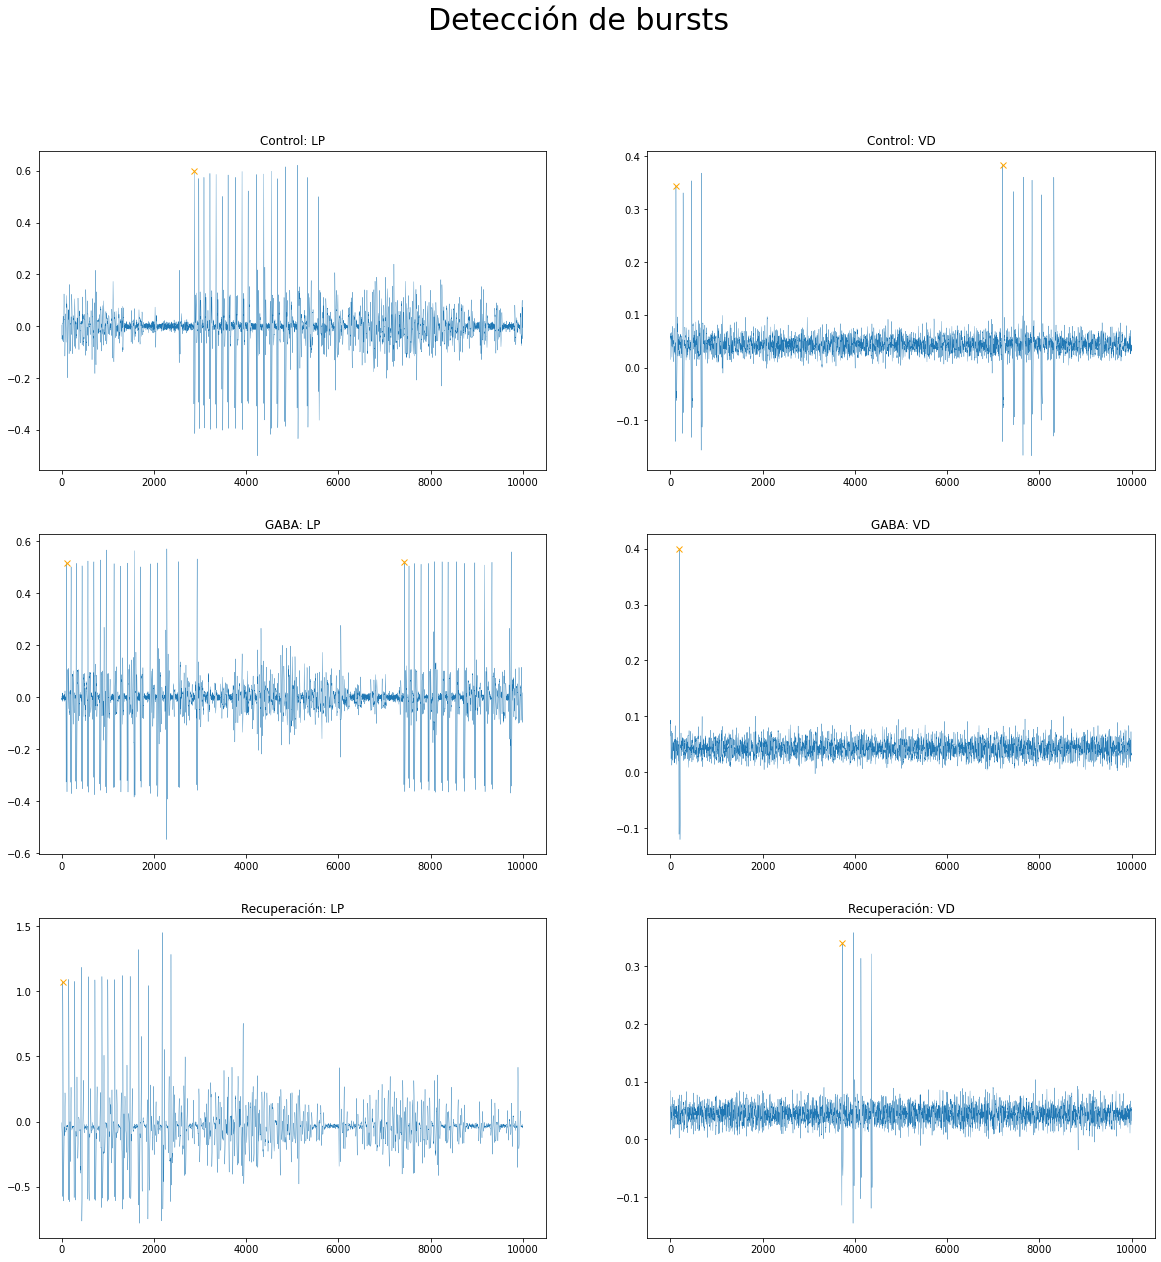

In [12]:
from_files = ["./DatosSinapsisArtificial/TrozoC.txt",
              "./DatosSinapsisArtificial/TrozoG.txt",
              "./DatosSinapsisArtificial/TrozoR.txt"]
bin_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
             "./DatosSinapsisArtificial/TrozoG_bin.csv",
             "./DatosSinapsisArtificial/TrozoR_bin.csv"]
cols = [["LP", "VD"],
        ["LP", "VD", "GABA"],
        ["LP", "VD"]]
burst_cols = [["LP_burst", "VD_burst"],
              ["LP_burst", "VD_burst"],
              ["LP_burst", "VD_burst"]]
bin_cols = [["LP_bin", "VD_bin"],
            ["LP_bin", "VD_bin"],
            ["LP_bin", "VD_bin"]]
thresholds = [1000,1000,1000]
titles = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Detección de bursts", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], skiprows=3, 
                     header=None, names=cols[i], dtype=np.float, sep='\s+', decimal=',', index_col=False, nrows=10000)
    df2 = get_bursts(pd.read_csv(bin_files[i],nrows=10000), thresholds[i], bin_cols[i], burst_cols[i])
    
    plt.subplot(3,2,2*i+1)
    plt.plot(df["LP"], lw=0.3)
    plt.plot(df2[df2["LP_burst"] == 1]["LP"], 'x', c='orange')
    plt.title(f"{titles[i]}: LP")
    
    plt.subplot(3,2,2*i+2)
    plt.plot(df["VD"], lw=0.3)
    plt.plot(df2[df2["VD_burst"] == 1]["VD"], 'x', c='orange')
    plt.title(f"{titles[i]}: VD")

Estas gráficas representan un fragmento de la serie con los bursts etiquetados. Las cruces naranjas representan los unos en la serie e identifican el inicio de un burst.

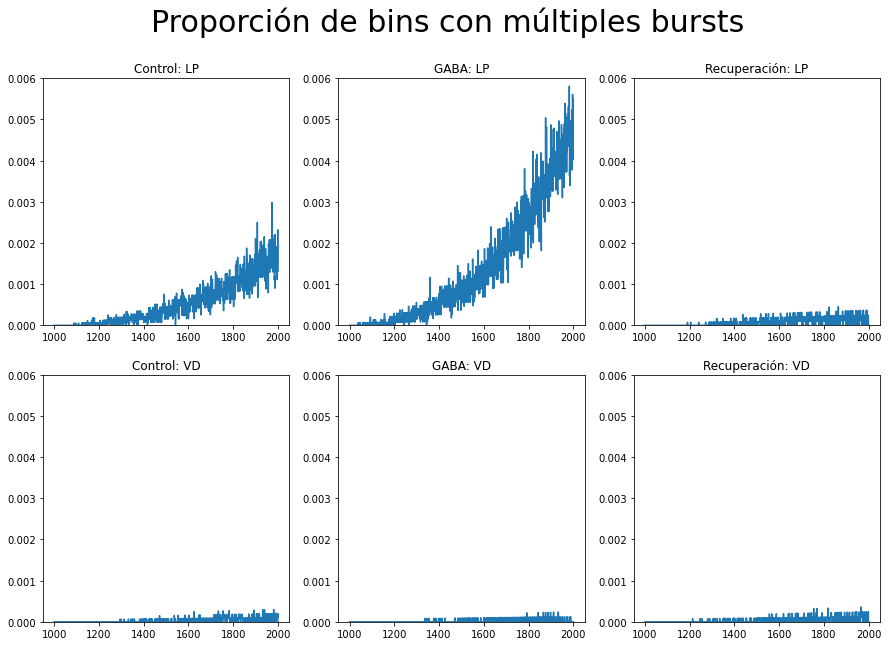

In [16]:
from_files = ["./DatosSinapsisArtificial/TrozoC_bin.csv",
              "./DatosSinapsisArtificial/TrozoG_bin.csv",
              "./DatosSinapsisArtificial/TrozoR_bin.csv"]
titles = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,10))
fig.suptitle("Proporción de bins con múltiples bursts", fontsize=30)
for i in range(len(from_files)):
    df = pd.read_csv(from_files[i], usecols=['LP_bin', 'VD_bin'])
    df = get_bursts(df, 1000, ['LP_bin', 'VD_bin'], ["LP_burst", "VD_burst"])[["LP_burst", "VD_burst"]]
    df = df.astype({"LP_burst":'u1', "VD_burst":'u1'})
    
    ers = [get_error_proportion(df, i) for i in range(1000,2001)]
    ers_LP = [a.LP_burst for a in ers]
    ers_VD = [a.VD_burst for a in ers]

    plt.subplot(2, 3, i+1)
    plt.plot(range(1000,2001), ers_LP)
    plt.title(f"{titles[i]}: LP")
    plt.ylim((0,0.006))

    plt.subplot(2, 3, i+4)
    plt.plot(range(1000,2001), ers_VD)
    plt.title(f"{titles[i]}: VD")
    plt.ylim((0,0.006))

En este caso se puede apreciar que la proporción de bins que contienen más de un burst es menor al $0.6\%$.

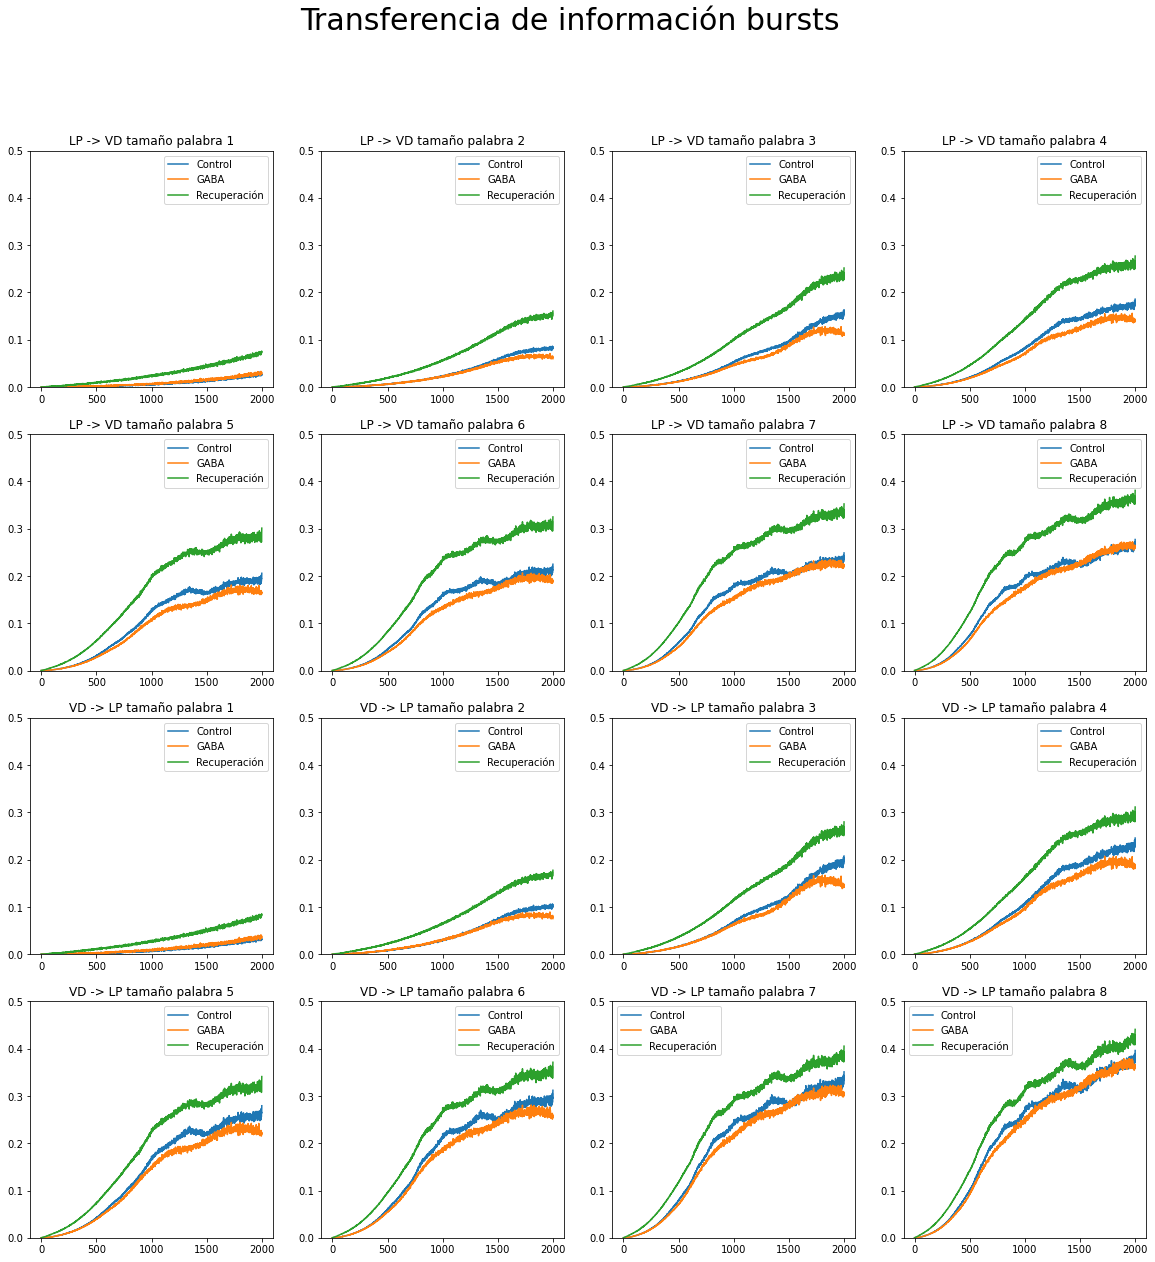

In [35]:
from_files = ["dataC_burst.pkl",
              "dataG_burst.pkl",
              "dataR_burst.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Transferencia de información bursts", fontsize=30)

for w in range(1,9):
    plt.subplot(4, 4, w)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["transfer_info_col1_col2"].reset_index(drop=True, inplace=True)
            plt.plot(data["transfer_info_col1_col2"][f"word_len {w}"], label=labels[i])
    plt.legend()
    plt.title(f"LP -> VD tamaño palabra {w}")
    plt.ylim((0,0.5))
    plt.subplot(4, 4, w+8)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["transfer_info_col2_col1"].reset_index(drop=True, inplace=True)
            plt.plot(data["transfer_info_col2_col1"][f"word_len {w}"], label=labels[i])
    plt.title(f"VD -> LP tamaño palabra {w}")
    plt.ylim((0,0.5))
    plt.legend()

Comparando con la transferencia de información con la codificación mediante spikes apreciamos que es prácticamente $3$ veces superior, llegando a valores de $0.45$ para los tamaños de palabra más grandes. Esto podría sugerir que la codificación por bursts se acerca más a la codificación real del sistema biológico que la codificación por spikes. Aún así sigue siendo GABA el que menor transferencia de información tiene y Recuperación el que más.

También apreciamos que la transferencia de VD a LP es superior a la de LP a VD. Lo visualizamos en los siguientes mapas de calor, que además dejan ver el crecimiento respecto a las variables tamaño de bin y de palabra.

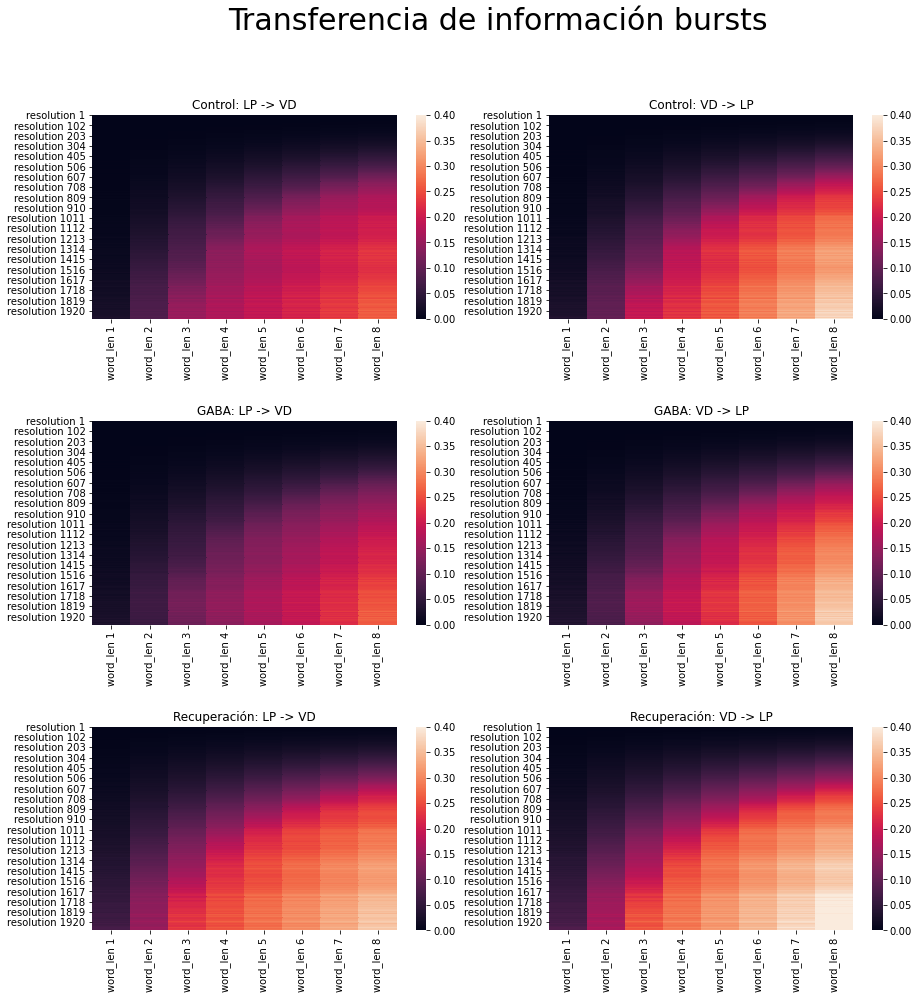

In [15]:
from_files = ["dataC_burst.pkl",
              "dataG_burst.pkl",
              "dataR_burst.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(15,15))
fig.suptitle("Transferencia de información bursts", fontsize=30)
plt.subplots_adjust(hspace=0.5)
for i in range(len(from_files)):
    with open(from_files[i], "rb") as f:
        data = pickle.load(f)
    plt.subplot(3, 2, 2*i + 1)
    sns.heatmap(data['transfer_info_col1_col2'].convert_dtypes(), vmin=0, vmax=0.4)
    plt.title(f"{labels[i]}: LP -> VD")
    plt.subplot(3, 2, 2*i + 2)
    sns.heatmap(data['transfer_info_col2_col1'].convert_dtypes(), vmin=0, vmax=0.4)
    plt.title(f"{labels[i]}: VD -> LP")

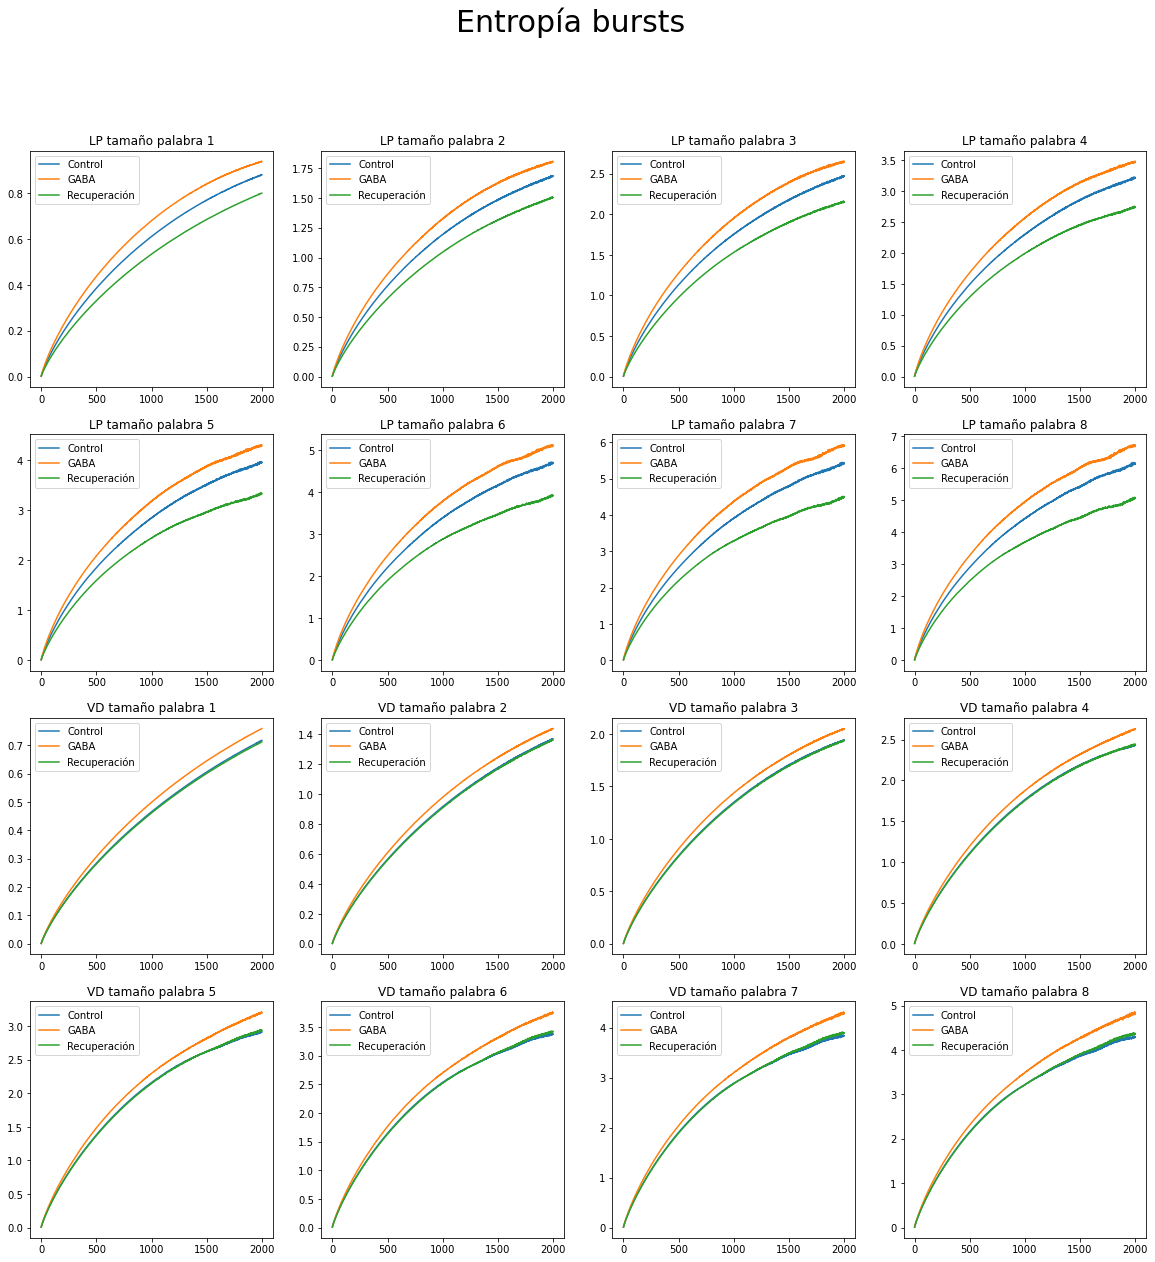

In [17]:
from_files = ["dataC_burst.pkl",
              "dataG_burst.pkl",
              "dataR_burst.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,20))
fig.suptitle("Entropía bursts", fontsize=30)

for w in range(1,9):
    plt.subplot(4, 4, w)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["col1_entropy"].reset_index(drop=True, inplace=True)
            plt.plot(data["col1_entropy"][f"word_len {w}"], label=labels[i])
    plt.legend()
    plt.title(f"LP tamaño palabra {w}")
    plt.subplot(4, 4, w+8)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["col2_entropy"].reset_index(drop=True, inplace=True)
            plt.plot(data["col2_entropy"][f"word_len {w}"], label=labels[i])
    plt.title(f"VD tamaño palabra {w}")
    plt.legend()

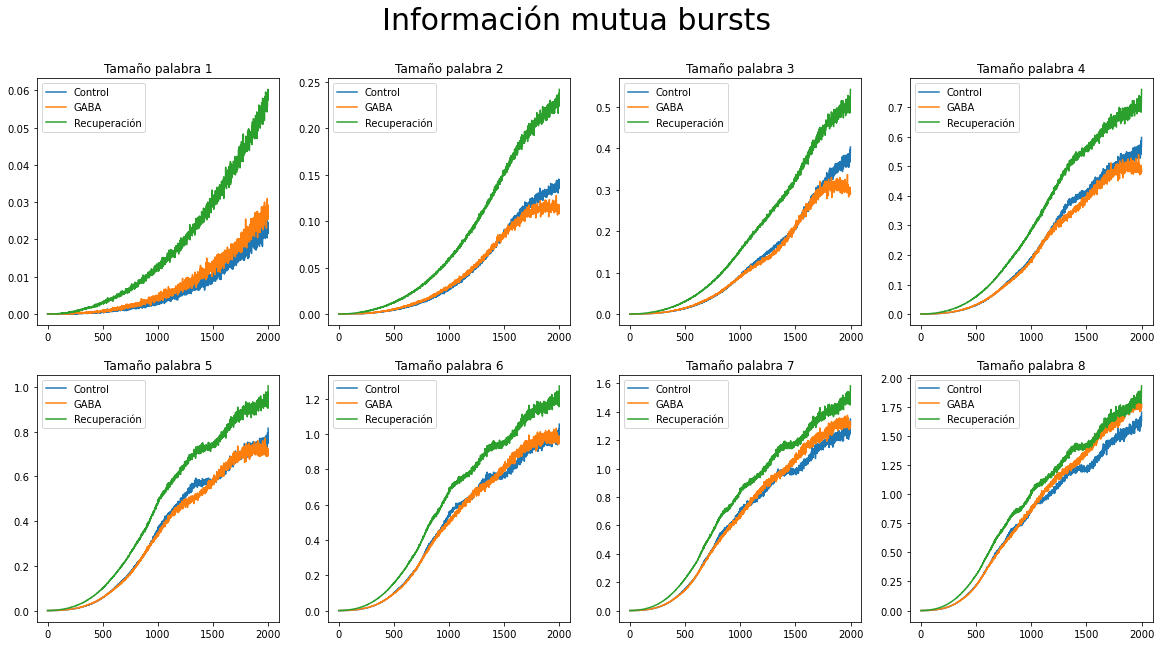

In [15]:
from_files = ["dataC_burst.pkl",
              "dataG_burst.pkl",
              "dataR_burst.pkl"]
labels = ["Control", "GABA", "Recuperación"]
fig = plt.figure(figsize=(20,10))
fig.suptitle("Información mutua bursts", fontsize=30)

for w in range(1,9):
    plt.subplot(2, 4, w)
    for i in range(len(from_files)):
        with open(from_files[i], "rb") as f:
            data = pickle.load(f)
            data["mutual_info"].reset_index(drop=True, inplace=True)
            plt.plot(data["mutual_info"][f"word_len {w}"], label=labels[i])
    plt.legend()
    plt.title(f"Tamaño palabra {w}")

Vemos que con esta codificación el fenómeno que ocurría con la codificación de spikes no tiene tanta presencia.

# Conclusiones

Hemos experimentado de primera mano el proceso de investigación mediante técnicas de teoría de la información para tratar de entender los fenómenos sucedidos dentro de un sistema biológico real.

Nos ha resultado de especial interés la influencia inhibitoria de la neurona LP sobre VD que se refleja en la transferencia de información entre ambas neuronas. Dado que el GABA es un neurotransmisor inhibidor, podemos comprobar que el comportamiento del sistema es similar a lo que esperaríamos.

También hemos comprobado la diferencia que se produce al cambiar el sistema de codificación. Esto nos enseña la importancia de esta elección a la hora de analizar cualquier serie temporal.